In [4]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import os
import numpy as np
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [5]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [35]:
train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1034 files belonging to 3 classes.


In [36]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 133 files belonging to 3 classes.


In [37]:
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 128 files belonging to 3 classes.


In [38]:
class_names = train_data.class_names
print(class_names)

['angular_leaf_spot', 'bean_rust', 'healthy']


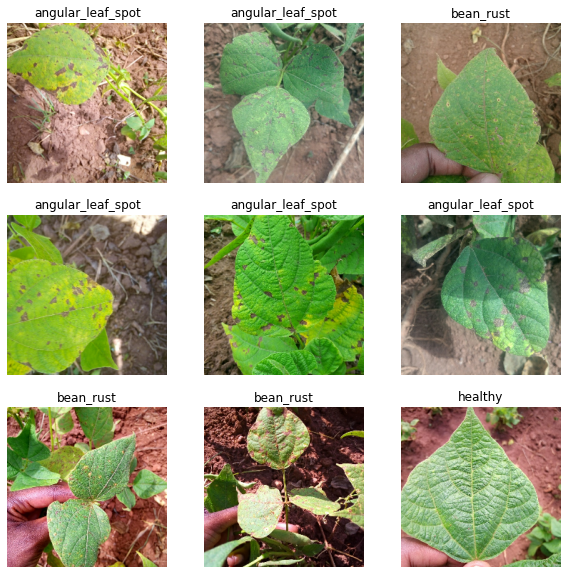

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [40]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
normalization_layer = layers.Rescaling(1./255)

In [43]:
normalized_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [54]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(224, 224, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)       

In [57]:
epochs=10
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/10
33/33 [==============================] - 12s 358ms/step - loss: 1.5210 - accuracy: 0.4159 - val_loss: 0.9321 - val_accuracy: 0.5188
Epoch 2/10
33/33 [==============================] - 12s 359ms/step - loss: 0.8562 - accuracy: 0.5822 - val_loss: 0.7111 - val_accuracy: 0.6767
Epoch 3/10
33/33 [==============================] - 12s 360ms/step - loss: 0.6908 - accuracy: 0.6925 - val_loss: 0.6754 - val_accuracy: 0.6917
Epoch 4/10
33/33 [==============================] - 12s 376ms/step - loss: 0.6204 - accuracy: 0.7224 - val_loss: 0.7673 - val_accuracy: 0.6842
Epoch 5/10
33/33 [==============================] - 13s 381ms/step - loss: 0.5247 - accuracy: 0.7698 - val_loss: 0.5053 - val_accuracy: 0.7970
Epoch 6/10
33/33 [==============================] - 13s 381ms/step - loss: 0.4258 - accuracy: 0.8356 - val_loss: 0.5834 - val_accuracy: 0.7444
Epoch 7/10
33/33 [==============================] - 13s 381ms/step - loss: 0.4378 - accuracy: 0.8153 - val_loss: 0.6014 - val_accuracy: 0.8045

In [58]:
result = model.evaluate(test_data)

4/4 [==============================] - 1s 119ms/step - loss: 0.5405 - accuracy: 0.8047


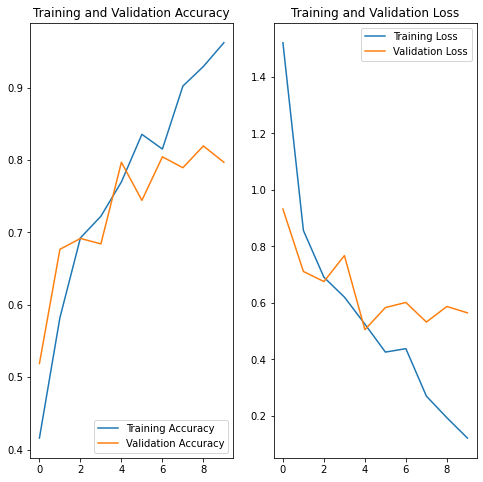

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(224,
                                  224,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

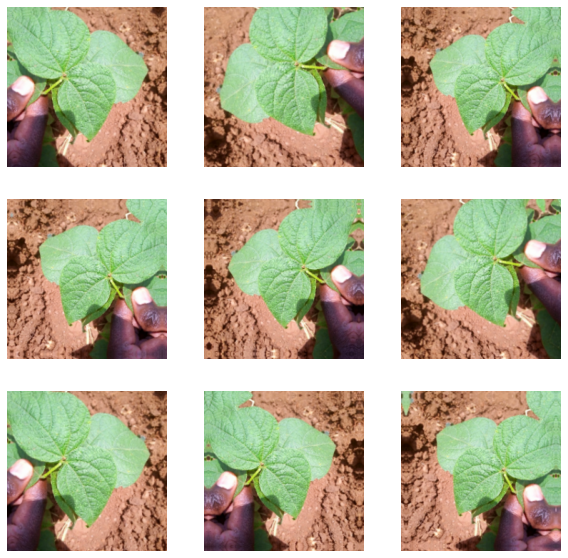

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [53]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                  

In [26]:
epochs = 5
history = model.fit(
  train_data,
  validation_data=validation_data,
  epochs=epochs
)

Epoch 1/5
33/33 [==============================] - 14s 409ms/step - loss: 1.3012 - accuracy: 0.4545 - val_loss: 0.8876 - val_accuracy: 0.5263
Epoch 2/5
33/33 [==============================] - 13s 401ms/step - loss: 0.8513 - accuracy: 0.6103 - val_loss: 0.7162 - val_accuracy: 0.7143
Epoch 3/5
33/33 [==============================] - 13s 407ms/step - loss: 0.7659 - accuracy: 0.6663 - val_loss: 0.8176 - val_accuracy: 0.6617
Epoch 4/5
33/33 [==============================] - 14s 410ms/step - loss: 0.6814 - accuracy: 0.7070 - val_loss: 0.5984 - val_accuracy: 0.7744
Epoch 5/5
33/33 [==============================] - 14s 410ms/step - loss: 0.6548 - accuracy: 0.7340 - val_loss: 0.5646 - val_accuracy: 0.7444


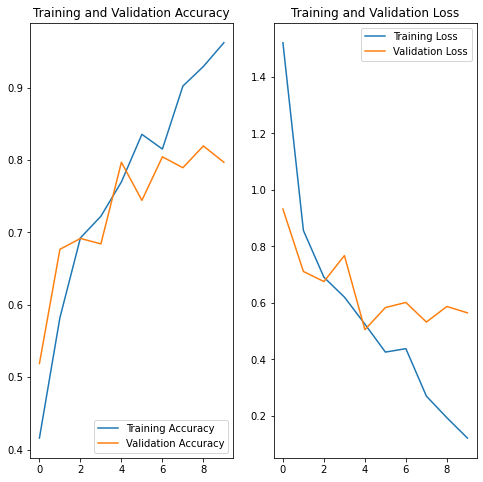

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [61]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(224, 224)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to bean_rust with a 100.00 percent confidence.


This image most likely belongs to healthy with a 99.96 percent confidence.


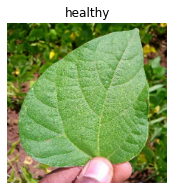

In [86]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    img_array = tf.keras.utils.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [87]:
#create folder to save the model
!mkdir -p Final_Model
model.save('Models2/last_bean_model')#model.save("your path")

INFO:tensorflow:Assets written to: Models2/last_bean_model/assets


INFO:tensorflow:Assets written to: Models2/last_bean_model/assets


In [88]:
#my_model directory
!ls Models2

last_bean_model


In [89]:
new_model = tf.keras.models.load_model('Models2/last_bean_model')

# Check its architecture
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 64)       

In [90]:
result = new_model.evaluate(test_data)

4/4 [==============================] - 1s 129ms/step - loss: 0.5405 - accuracy: 0.8047


[[-2.7574394 17.925278   7.228459 ]]


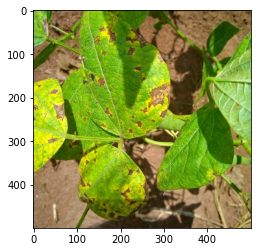

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.777218 17.891035  7.24265 ]]


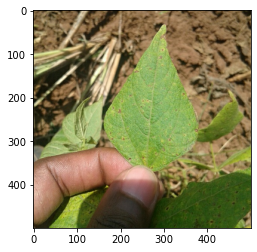

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.8122816 17.888857   7.277791 ]]


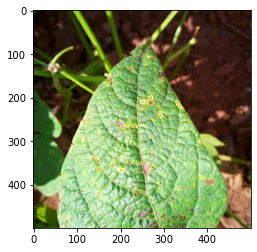

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.8055766 17.841059   7.263294 ]]


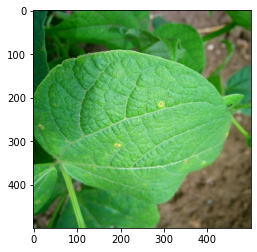

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.8224356 17.860048   7.2859955]]


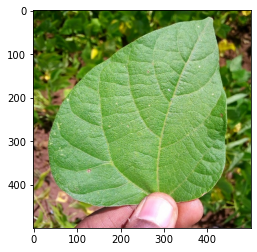

Actual Label : healthy
Predicted Label : bean_rust
[[-2.7870243 17.925516   7.261059 ]]


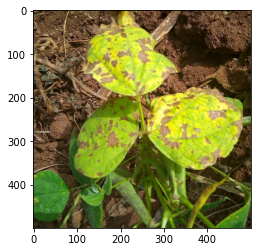

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.7892568 17.85188    7.2474422]]


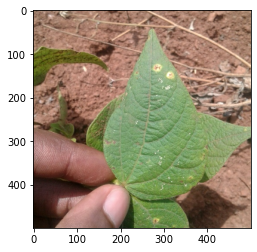

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.7803292 17.900494   7.247131 ]]


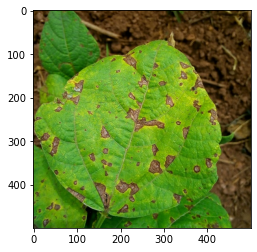

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.788464 17.912771  7.259026]]


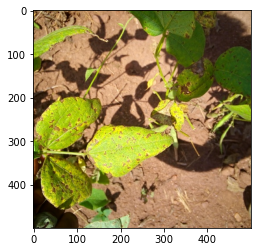

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.7655573 17.91057    7.2424912]]


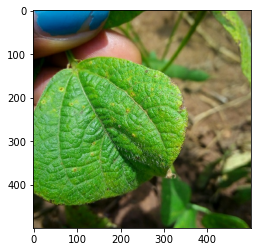

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.7501497 17.911657   7.221941 ]]


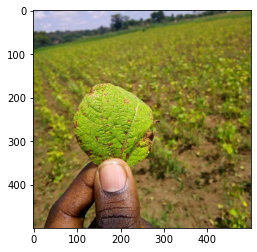

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.7826304 17.855383   7.2426825]]


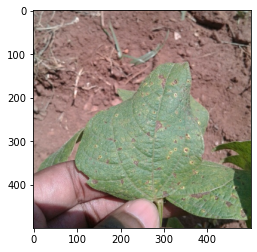

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.797922 17.908401  7.266718]]


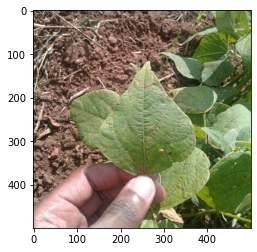

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.7619438 17.861223   7.2246237]]


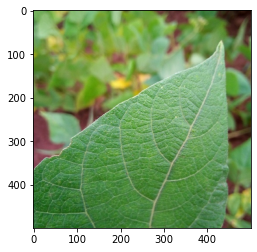

Actual Label : healthy
Predicted Label : bean_rust
[[-2.819906  17.910362   7.2917085]]


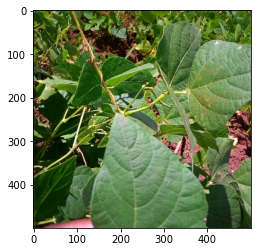

Actual Label : healthy
Predicted Label : bean_rust
[[-2.8234887 17.891842   7.2878675]]


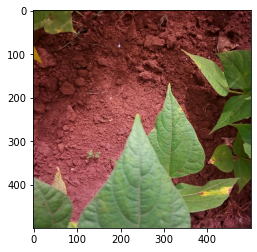

Actual Label : healthy
Predicted Label : bean_rust
[[-2.7782042 17.907038   7.2519617]]


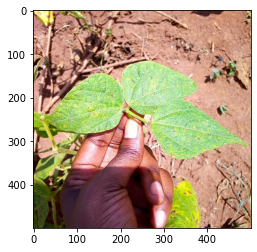

Actual Label : bean_rust
Predicted Label : bean_rust
[[-2.8030794 17.90716    7.274895 ]]


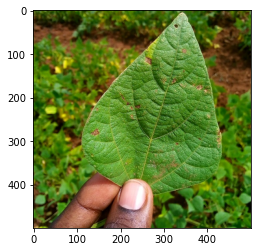

Actual Label : angular_leaf_spot
Predicted Label : bean_rust
[[-2.7864249 17.860643   7.2473927]]


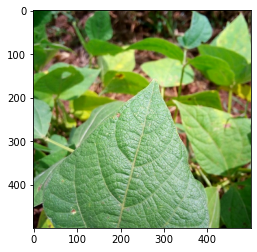

Actual Label : healthy
Predicted Label : bean_rust
[[-2.7820184 17.890701   7.2476873]]


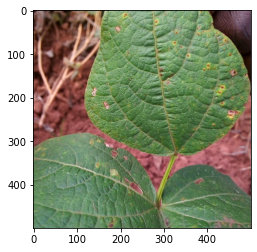

Actual Label : bean_rust
Predicted Label : bean_rust


2022-11-19 22:47:37.745055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [91]:
datasets , info = tfds.load(name = 'beans', with_info = True, as_supervised = True, split = ['train', 'test', 'validation'])

def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    
    return tf.image.resize(image, [224, 224]), tf.one_hot(label, 3)
for test_sample in datasets[1].take(20):
    image, label = test_sample[0], test_sample[1]
    image_scaled, label_arr = scale(test_sample[0], test_sample[1])
    image_scaled = np.expand_dims(image_scaled, axis = 0)
    
    img = tf.keras.preprocessing.image.img_to_array(image)
    
    pred = new_model.predict(image_scaled,verbose=False)
    
    print(pred)
    
    plt.figure()
    plt.imshow(image)
    plt.show()
    
    print("Actual Label : %s" %info.features['label'].names[label.numpy()])
    print("Predicted Label : %s" %info.features['label'].names[np.argmax(pred)])